## Purpose
The purpose of this application is to solve relevant classification and regression problems for the prostate dataset for use in the project in 02450 Intro to Machine Learning

Author: Naia Wright

Reviewed by:  

Last modified: 28/10/18, 09:39

#### Change-log


Import of required packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from scipy.linalg import svd

from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import sklearn.linear_model as lm
from matplotlib.pylab import figure, plot, xlabel, ylabel, legend, ylim, show

from matplotlib.pyplot import figure, boxplot, xlabel, ylabel, show
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection, tree
from scipy import stats

from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection

from matplotlib.pyplot import figure, plot, subplot, title, bar, xlabel, ylabel, show, clim, xticks
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import feature_selector_lr, bmplot
import numpy as np

from statistics import mean
import graphviz
from numpy import array
from scipy import stats

import os

import neurolab as nl


#### Import of data

First we define a method for importing a spread_sheet using pandas

In [2]:
def DataLoader(path, sheet):
    """
    Method for importing data from a spreadsheet.

    :param path: full path to the spreadsheet to load
    :param sheet: name of the sheet in the workbook that is loaded
    :return: pandas dataFrame with imported data
    """
    import pandas as pd

    out = pd.read_excel(path, sheet_name=sheet)

    return out

In [3]:
# Specify path and sheet name in the prostate workbook
base_dir = os.getcwd()
filePath = base_dir + '/Data/Prostate.xlsx'
#filePath = 'C:/Users/PeterBakke/Documents/git/ML_fall2018/Data/Prostate.xlsx'
#filePath = 'C:/Users/Greta/Documents/Github/ML_fall2018/Data/Prostate.xlsx'
#filePath = 'C:/Users/narisa/Documents/GitHub/ML_fall2018/Data/Prostate.xlsx'
sheet = 'Sheet1'

seed = 1337

In [4]:
# load prostate data into dataFrame
myData = DataLoader(path=filePath, sheet=sheet)

# delete irrelevant columns
del myData['ID']
del myData['train']

In [5]:
# Extract class names 
attributeNames = list(myData.columns.values)

# Convert dataFrame to numpy array
X = myData.values

# Compute values of N (observations) and M (features)
M = len(attributeNames)
N = X.shape[0]

print(attributeNames)

['lCaVol', 'lWeight', 'Age', 'lBPH', 'SVI', 'lCP', 'Gleason', 'pgg45', 'lPSA']


In [6]:
# Extracting and deleting PGG45 and Gleason from X, as well as SVI (to not normalize SVI)
X_orig = np.copy(X)

gleason = X_orig[:,6]
pgg = X_orig[:,7]
svi = X_orig[:,4]

# print(X)

In [7]:
# OBS - only run this once
X = np.delete(X,6,1) # Deletes Gleason
X = np.delete(X,6,1) # Deletes PGG
X = np.delete(X,4,1) # Deletes SVI

In [8]:
# Z score all other variables 
X_z = zscore(X)
# print(X_z)

# Current order: lCavol, lWeight, Age, lBPH, lCP, lPSA

In [9]:
# One out of K coding for PGG and Gleason

from categoric2numeric import *

[X_Gleason, attribute_names_Gleason]=categoric2numeric(gleason)
[X_PGG45, attribute_names_PGG45]=categoric2numeric(pgg)

#print(X_Gleason)

In [10]:
# Add one out of K coded Gleason and PGG columns, as well as SVI 
svi = np.reshape(svi,[97,1])
print(svi.shape)
# X_k = np.concatenate((X,X_Gleason,X_PGG45,svi),axis=1)
X_k = np.concatenate((X_z,X_Gleason,svi),axis=1)

print(X_k.shape)
print(X_k[2])

# Order: lCavol, lWeight, Age, lBPH, lCP, lPSA, Gleason (4 columns), (PGG (19 columns)), SVI (1 column)


(97, 1)
(97, 11)
[-1.58702059 -2.20015441  1.36823439 -1.03002898 -0.86765522 -2.29971238
  0.          1.          0.          0.          0.        ]


In [11]:
# Remove attribute 10 (SVI) and Gleason from X
X_classification = X_k[:,[0,1,2,3,4,5,6,7,8,9]]

# Use attribute 5 (SVI) as y
y_classification = X_k[:,10]


In [12]:
N, M = X_classification.shape

print(N)
print(M)

97
10


In [13]:
# extract class names and encode with integers (dict)

#classLabels = myData['Gleason'].values.tolist()
#classNames = sorted(set(classLabels))
#classDict = dict(zip(classNames, range(4)))

#del myData['Gleason']

#attributeNames = list(myData.columns.values)

#print(attributeNames)
#print(classDict)

In [14]:
# Extract vector y, convert to NumPy array
#y = np.asarray([classDict[value] for value in classLabels])

# Convert dataFrame to numpy array
#X = myData.values

# Compute values of N, M and C
#N = len(y)
#M = len(attributeNames)
#C = len(classNames)

In [15]:
# Normalize data with mean and std
#Y = (X - np.ones((N,1))*X.mean(axis=0)) / X.std(axis=0)
print(y_classification)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1.]


## Classification

In [16]:
# Remove attribute 5 (SVI) from X
#X_classification = Y[:,[0,1,2,3,5,6,7,8]]
#print(X_classification)
# Use attribute 5 (SVI) as y
#y_classification = X[:,4]
#print(y_classification)
# Remove attribute 5 (SVI) from attribute names

#lCavol, lWeight, Age, lBPH, lCP, lPSA, Gleason (4 columns), (PGG (19 columns)), SVI (1 column)

attributeNames_classification = np.array(['lCavol', 'lWeight', 'Age', 'lBPH', 'lCP', 'lPSA', 'Gleason 1', 'Gleason 2', 'Gleason 3', 'Gleason 4'])
print(attributeNames_classification)


['lCavol' 'lWeight' 'Age' 'lBPH' 'lCP' 'lPSA' 'Gleason 1' 'Gleason 2'
 'Gleason 3' 'Gleason 4']


# Q2

## Two level cross validation for KNN - Naia 2018-11-03 

In [17]:
## Crossvalidation for KNN
## The selection of optimal model is based on an average of the inner errors for each model

# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True, random_state=seed)
#CV = model_selection.StratifiedKFold(n_splits=K)
index_min_lst = []
min_indices = []
error_outer = [] # List for the errors in outer CV fold
dict_inner = {}
error_inner = {} # Dict with the errors in the innter CV fold for each tested model
K_KNN = range(1,41) # Change here for different nearest neighbour crossvalidation - test of K=1-40

for count, value in enumerate(K_KNN):
    error_inner['K_KNN_of_{0}'.format(value)] = []

k=0
classifier_lst = []

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True, random_state=seed)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        
        for count, value in enumerate(K_KNN):
            dist=2 #euclidean_distance
                       
            knclassifier = KNeighborsClassifier(n_neighbors=value, p=dist);
            knclassifier.fit(X_train_inner, y_train_inner);
            classifier_lst.append(knclassifier)
            
            y_KNN = knclassifier.predict(X_test_inner);
            errorKNN_inner = 100*(y_KNN!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            #index_min_lst.append(errorKNN_inner) #Append the error values to a list
            error_inner['K_KNN_of_{0}'.format(value)].append(errorKNN_inner) # add errors for each fold to each model
            
        kk += 1
        
    # Find the KNN value with minimum average error value
    for key in error_inner.keys():
        index_min_lst.append(mean(error_inner[key]))
        
    print('Inner_error_values are:' + str(index_min_lst))
    index_min = np.argmin(index_min_lst) #Find the index of the minimum error value
    top_count = index_min
    min_indices.append(index_min) 
        
    index_min_lst = [] # Clear for next CV fold
    
    for key in error_inner.keys():
        error_inner[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal KNN value is: ' + str(top_count))
    
    optimal_K = K_KNN[top_count]
    
    print('The optimal KNN value across inner CV folds is: ' + str(optimal_K))
    
    knclassifierOuter = KNeighborsClassifier(n_neighbors=optimal_K, p=dist); #Uses optimal_K, which was found in the inner CV loop
    knclassifierOuter.fit(X_train_outer, y_train_outer);
            
    y_KNN_outer = knclassifierOuter.predict(X_test_outer);
    errorKNN_outer = 100*(y_KNN_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer.append(errorKNN_outer)
    print('Errors for each outer CV fold: ' + str(error_outer))
error_KNN = error_outer

CV-fold 1 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
Inner_error_values are:[15.75, 18.166666666666668, 14.25, 16.833333333333332, 14.25, 15.5, 11.666666666666668, 14.166666666666668, 12.916666666666666, 14.166666666666668, 14.166666666666668, 14.083333333333334, 12.916666666666668, 11.583333333333334, 11.583333333333334, 11.583333333333334, 11.583333333333334, 12.833333333333334, 11.583333333333334, 15.416666666666668, 14.166666666666668, 15.416666666666668, 12.833333333333334, 19.333333333333332, 19.333333333333332, 18.0, 18.083333333333332, 21.916666666666668, 21.916666666666668, 21.916666666666668, 21.916666666666668, 24.583333333333336, 24.583333333333336, 24.583333333333336, 24.583333333333336, 24.583333333333336, 24.583333333333336, 24.583333333333336, 24.583333333333336, 24.583333333333336]
The index of optimal KNN value is: 13
The optimal KNN value across inner CV folds is: 14
Errors for each outer CV fold: [20

## Two level cross validation for decision trees

In [18]:
## Crossvalidation for decision trees
## The selection of optimal model is based on an average of the inner errors for each model

# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True, random_state=seed)
#CV = model_selection.StratifiedKFold(n_splits=K)
index_min_lst = []
min_indices = []
error_outer = [] # List for the errors in outer CV fold
dict_inner = {}
error_inner = {} # Dict with the errors in the innter CV fold for each tested model
# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 20, 1)
print(tc)


for count, value in enumerate(tc):
    error_inner['tc_of_{0}'.format(value)] = []

k=0
classifier_lst = []

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True, random_state=seed)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        
        for count, value in enumerate(tc):
            dist=1
            
            # Fit decision tree classifier, Gini split criterion, different pruning levels
            dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=value) 
            dtc.fit(X_train_inner, y_train_inner.ravel());
            classifier_lst.append(dtc)
            
            y_dtc = dtc.predict(X_test_inner);
            errordtc_inner = 100*(y_dtc!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            #index_min_lst.append(errorKNN_inner) #Append the error values to a list
            error_inner['tc_of_{0}'.format(value)].append(errordtc_inner) # add errors for each fold to each model
            
        kk += 1
        
    # Find the KNN value with minimum average error value
    for key in error_inner.keys():
        index_min_lst.append(mean(error_inner[key]))
        
    print('Inner_error_values are:' + str(index_min_lst))
    index_min = np.argmin(index_min_lst) #Find the index of the minimum error value
    top_count = index_min
    min_indices.append(index_min) 
        
    index_min_lst = [] # Clear for next CV fold
    
    for key in error_inner.keys():
        error_inner[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal tc value is: ' + str(top_count))
    
    optimal_tc = tc[top_count]
    
    print('The optimal tc value across inner CV folds is: ' + str(optimal_tc))
    
    
    dtcclassifierOuter = tree.DecisionTreeClassifier(criterion='gini', max_depth=optimal_tc);  #Uses optimal_tc, which was found in the inner CV loop
    dtcclassifierOuter.fit(X_train_outer, y_train_outer.ravel());
            
    y_dtc_outer = dtcclassifierOuter.predict(X_test_outer);
    errordtc_outer = 100*(y_dtc_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer.append(errordtc_outer)
    print('Errors for each outer tc fold: ' + str(error_outer))

error_dct = error_outer

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
CV-fold 1 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
Inner_error_values are:[13.0, 14.333333333333334, 16.916666666666668, 14.333333333333334, 14.416666666666668, 14.416666666666668, 13.083333333333334, 15.583333333333334, 16.916666666666668, 14.333333333333334, 16.916666666666668, 18.166666666666668, 16.916666666666668, 14.416666666666668, 14.416666666666668, 15.583333333333334, 14.416666666666668, 14.416666666666668]
The index of optimal tc value is: 0
The optimal tc value across inner CV folds is: 2
Errors for each outer tc fold: [15.0]
CV-fold 2 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
Inner_error_values are:[16.916666666666668, 13.083333333333334, 11.666666666666668, 9.083333333333334, 12.916666666666668, 10.416666666666668, 12.916666666666668, 10.416666666666668, 14.25, 10.416666666666668, 1

Text(0,0.5,'Cross-validation error [%]')

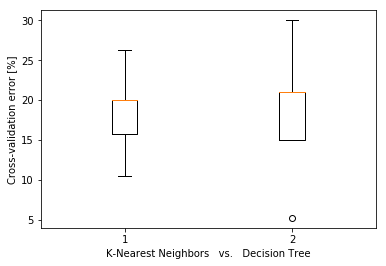

In [19]:
figure()
boxplot([error_KNN, error_dct])
xlabel('K-Nearest Neighbors   vs.   Decision Tree')
ylabel('Cross-validation error [%]')

# Q3

In [20]:
# Method selected: Decision Trees

In [21]:
# Re-estimate of the model on all data for a maximum depth of 5

# Fit decision tree classifier, Gini split criterion, maximum depth of 5 on all data
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=5) 
dtc.fit(X_classification, y_classification.ravel())

# New data object
new_data = np.array([2, 2, 4, -1, -1, -3, 0, 0, 0, 1]).reshape(1,-1) # Gives 0 - No SVI
#new_data = np.array([2, 2, 4, -1, 2, -3, 0, 0, 0, 1]).reshape(1,-1) # Gives 1 - Yes SVI

# Evalulate the decision tree for a new data object
new_data_class = dtc.predict(new_data)[0]
print(new_data_class)

0.0


In [22]:
print(new_data)

[[ 2  2  4 -1 -1 -3  0  0  0  1]]


In [23]:
print(attributeNames_classification)

['lCavol' 'lWeight' 'Age' 'lBPH' 'lCP' 'lPSA' 'Gleason 1' 'Gleason 2'
 'Gleason 3' 'Gleason 4']


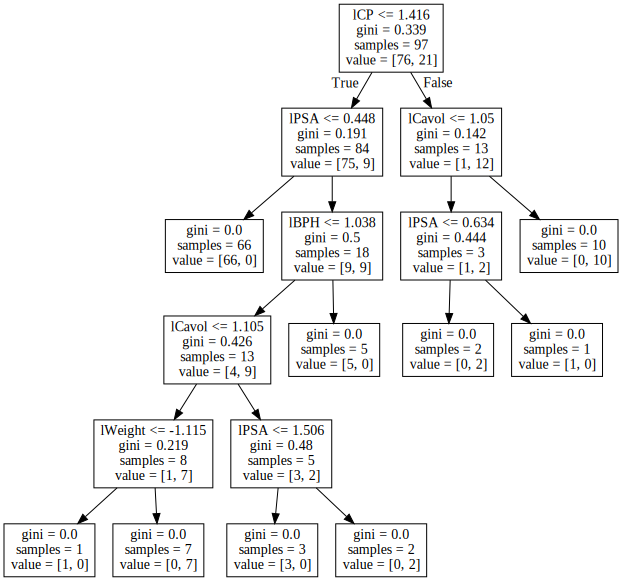

In [24]:
# Export tree graph for visualization purposes:
# (note: you can use i.e. Graphviz application to visualize the file)
out = tree.export_graphviz(dtc, out_file='tree_gini.gvz', feature_names=attributeNames_classification)
#graphviz.render('dot','png','tree_gini',quiet=False)
src=graphviz.Source.from_file('tree_gini.gvz')
## Comment in to automatically open pdf
## Note. If you get an error (e.g. exit status 1), try closing the pdf file/viewer
#src.render('../tree_gini', view=True)
src

# ANN For Classification

In [25]:
# Parameters for neural network classifier
n_hidden_units = [2,4,6,8,10,15]      # number of hidden units
n_train = 6             # number of networks trained in each k-fold
learning_goal = 0.0001     # stop criterion 1 (train mse to be reached)
max_epochs = 512         # stop criterion 2 (max epochs in training)
show_error_freq = 100     # frequency of training status updates

In [26]:
# K-fold crossvalidation
K = 5                   # only three folds to speed up this example
CV = model_selection.KFold(K,shuffle=True, random_state=seed)

In [27]:
# Variable for classification error
errors = np.zeros(K)*np.nan
gen_error = np.zeros(K)*np.nan
error_hist = np.zeros((max_epochs,K))*np.nan
bestnet = list()
k=0
for train_index, test_index in CV.split(X_classification,y_classification):
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    
    # extract training and test set for current CV fold
    X_train = X_classification[train_index,:]
    y_train = y_classification[train_index]
    X_test = X_classification[test_index,:]
    y_test = y_classification[test_index]
    
    best_train_error = np.inf
    for i in range(n_train):
        print('Training network {0}/{1}...'.format(i+1,n_train))
        # Create randomly initialized network with 2 layers
        ann = nl.net.newff([[-10,10]]*M, [n_hidden_units[i], 1], [nl.trans.LogSig(),nl.trans.LogSig()])
        if i==0:
            bestnet.append(ann)
        # train network
        train_error = ann.train(X_train, y_train.reshape(-1,1), goal=learning_goal, epochs=max_epochs, show=show_error_freq, rr=0.3)
        
        if train_error[-1]<best_train_error:
            bestnet[k]=ann
            best_train_error = train_error[-1]
            error_hist[range(len(train_error)),k] = train_error
            best_no_neurons = n_hidden_units[i]

    print('Best train error: {0}...'.format(best_train_error))
    print('Optimal number of hidden neurons: {0}...'.format(best_no_neurons))
    y_est = bestnet[k].sim(X_test).squeeze()
    y_est = (y_est>.5).astype(int)
    errors[k] = np.power(y_est-y_test,2).sum().astype(float)/y_test.shape[0]
    #errors[k] = 100*(y_est!=y_test).sum().astype(float)/y_test.shape[0]
    gen_error[k] = 100 * (y_est-y_test).sum().astype(float)/y_test.shape[0]
    #errors[k] = - y_test * np.log(y_est) - (1 - y_test) * np.log (1 - y_est)
    print(gen_error[k])
    k+=1
    #break
    




Crossvalidation fold: 1/5
Training network 1/6...
Training network 2/6...
Training network 3/6...
Training network 4/6...
Training network 5/6...
Training network 6/6...
Best train error: 2.38289712506086...
Optimal number of hidden neurons: 8...
5.0

Crossvalidation fold: 2/5
Training network 1/6...
Training network 2/6...
Training network 3/6...
Training network 4/6...
Training network 5/6...
Training network 6/6...
Best train error: 2.2451885869100288...
Optimal number of hidden neurons: 8...
-5.0

Crossvalidation fold: 3/5
Training network 1/6...
Training network 2/6...
Training network 3/6...
Training network 4/6...
Training network 5/6...
Training network 6/6...
Best train error: 2.619406190614707...
Optimal number of hidden neurons: 4...
-15.789473684210526

Crossvalidation fold: 4/5
Training network 1/6...
Training network 2/6...
Training network 3/6...
Training network 4/6...
Training network 5/6...
Training network 6/6...
Best train error: 3.3238834743615366...
Optimal numbe

Mean-square error: 0.14421052631578948


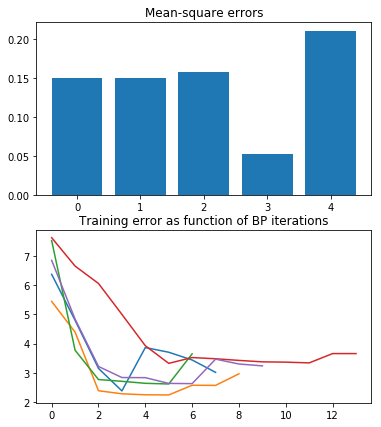

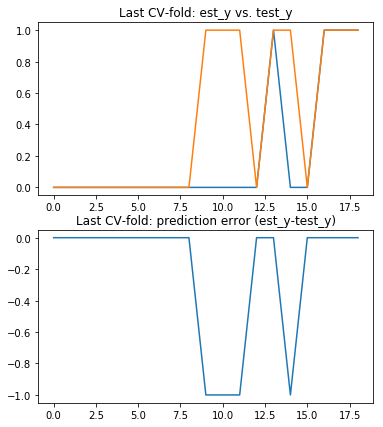

In [28]:
# Print the average least squares error
print('Mean-square error: {0}'.format(np.mean(errors)))

figure(figsize=(6,7));
subplot(2,1,1); bar(range(0,K),errors); title('Mean-square errors');
subplot(2,1,2); plot(error_hist); title('Training error as function of BP iterations');
figure(figsize=(6,7));
subplot(2,1,1); plot(y_est); plot(y_test); title('Last CV-fold: est_y vs. test_y'); 
subplot(2,1,2); plot((y_est-y_test)); title('Last CV-fold: prediction error (est_y-test_y)'); 
show()




# Q4

### Baseline model

In [29]:
# Baseline model
# zero rule algorithm for classification
def Baseline_model(y_train, y_test):
    prediction = stats.mode(y_train)[0]
    predicted = [int(prediction) for i in range(len(y_test))]
    return predicted

### Two-level-cross validation for dtc, KNN and baseline model

In [38]:
# Results from the 2-level cross-validation for dtc 
# Errors for each outer tc fold: [15.0, 30.0, 10.526315789473685, 10.526315789473685, 15.789473684210526]
# The errors for the best performing models are: 10.526315789473685, 15.0
## Crossvalidation for decision trees
## The selection of optimal model is based on an average of the inner errors for each model

# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True, random_state=seed)
#CV = model_selection.StratifiedKFold(n_splits=K)

# dtc
index_min_lst_dtc = []
min_indices_dtc = []
error_outer_dtc = [] # List for the errors in outer CV fold
dict_inner_dtc = {}
error_inner_dtc = {} # Dict with the errors in the innter CV fold for each tested model
# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 21, 1)
classifier_lst_dtc = []

for count, value in enumerate(tc):
    error_inner_dtc['tc_of_{0}'.format(value)] = []

# KNN
index_min_lst_KNN = []
min_indices_KNN = []
error_outer_KNN = [] # List for the errors in outer CV fold
dict_inner_KNN = {}
error_inner_KNN = {} # Dict with the errors in the innter CV fold for each tested model
K_KNN = range(1,41) # Change here for different nearest neighbour crossvalidation - test of K=1-40
classifier_lst_KNN = []

for count, value in enumerate(K_KNN):
    error_inner_KNN['K_KNN_of_{0}'.format(value)] = []
    

# ANN
ANN = []
index_min_lst_ANN = []
min_indices_ANN = []
error_outer_ANN = [] # List for the errors in outer CV fold
dict_inner_ANN = {}
error_inner_ANN = {} # Dict with the errors in the innter CV fold for each tested model
n_hidden_units = [2,4,6,8,10,15]      # number of hidden units
classifier_lst_ANN = []



for count, value in enumerate(n_hidden_units):
    error_inner_ANN['NO_HIDDEN_of_{0}'.format(value)] = []



    
# Baseline model
error_baseline = []



k=0

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True, random_state=seed)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        
    
    
    # ANN Classifier
        best_train_error = np.inf
        for i in range(n_train):
            #print('Training network {0}/{1}...'.format(i+1,n_train))
            # Create randomly initialized network with 2 layers
            ann = nl.net.newff([[-10,10]]*M, [n_hidden_units[i], 1], [nl.trans.LogSig(),nl.trans.LogSig()])
            if i==0:
                bestnet.append(ann)
            # train network
            train_error = ann.train(X_train, y_train.reshape(-1,1), goal=learning_goal, epochs=max_epochs, show=show_error_freq, rr=0.1)
            #print(train_error)
            
            
            if train_error[-1]<best_train_error:
                bestnet[k]=ann
                best_train_error = train_error[-1]
                error_hist[range(len(train_error)),kk] = train_error
                best_no_neurons = n_hidden_units[i]
                #print(1)
        #print('Best train error: {0}...'.format(best_train_error))
        #print('Optimal number of hidden neurons: {0}...'.format(best_no_neurons))
        y_est = bestnet[k].sim(X_test).squeeze()
        y_est = (y_est>.5).astype(int)
        #print(2)
        errors[kk] = np.power(y_est-y_test,2).sum().astype(float)/y_test.shape[0]
        #errors[kk] = 100*(y_est!=y_test).sum().astype(float)/y_test.shape[0]
        gen_error[kk] = 100 * (y_est-y_test).sum().astype(float)/y_test.shape[0]
        #print(gen_error[kk])
        #errors[k] = - y_test * np.log(y_est) - (1 - y_test) * np.log (1 - y_est)
        #print(gen_error[kk])
        errorANN_inner = 100*(y_est!=y_test).sum().astype(float)/len(y_test) 
        #print(best_no_neurons)
        #print(errorANN_inner)
        #print(value)
        error_inner_ANN['NO_HIDDEN_of_{0}'.format(best_no_neurons)].append(errorANN_inner) # add errors for each fold to each model
        #print(3)
    
    
        
    
    # Decision tree classifier
        for count, value in enumerate(tc):
            dist=1
            
            # Fit decision tree classifier, Gini split criterion, different pruning levels
            dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=value) 
            dtc.fit(X_train_inner, y_train_inner.ravel());
            classifier_lst_dtc.append(dtc)
            
            y_dtc = dtc.predict(X_test_inner);
            errordtc_inner = 100*(y_dtc!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            #index_min_lst.append(errorKNN_inner) #Append the error values to a list
            error_inner_dtc['tc_of_{0}'.format(value)].append(errordtc_inner) # add errors for each fold to each model
            #print('error_dtc is ' + str(error_inner_dtc))
   

    # KNN classifier
            for count, value in enumerate(K_KNN):
                dist=2 # euclidean_distance
                       
                knclassifier = KNeighborsClassifier(n_neighbors=value, p=dist);
                knclassifier.fit(X_train_inner, y_train_inner);
                classifier_lst_KNN.append(knclassifier)
            
                y_KNN = knclassifier.predict(X_test_inner);
                errorKNN_inner = 100*(y_KNN!=y_test_inner).sum().astype(float)/len(y_test_inner)  
                #index_min_lst.append(errorKNN_inner) #Append the error values to a list
                error_inner_KNN['K_KNN_of_{0}'.format(value)].append(errorKNN_inner) # add errors for each fold to each model
        
        
        kk += 1
    #dtc
    # Find the dtc value with minimum average error value
    for key in error_inner_dtc.keys():
        index_min_lst_dtc.append(mean(error_inner_dtc[key]))
        
    print('Inner_error_values_ for dtc are:' + str(index_min_lst_dtc))
    index_min_dtc = np.argmin(index_min_lst_dtc) #Find the index of the minimum error value
    top_count_dtc = index_min_dtc
    min_indices_dtc.append(index_min_dtc) 
        
    index_min_lst_dtc = [] # Clear for next CV fold
    
    for key in error_inner_dtc.keys():
        error_inner_dtc[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal tc value is: ' + str(top_count_dtc))
    
    optimal_tc = tc[top_count_dtc]
    
    print('The optimal tc value across inner CV folds is: ' + str(optimal_tc))
    
    
    dtcclassifierOuter = tree.DecisionTreeClassifier(criterion='gini', max_depth=optimal_tc);  #Uses optimal_tc, which was found in the inner CV loop
    dtcclassifierOuter.fit(X_train_outer, y_train_outer.ravel());
            
    y_dtc_outer = dtcclassifierOuter.predict(X_test_outer);
    errordtc_outer = 100*(y_dtc_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer_dtc.append(errordtc_outer)
    print('Errors for each outer tc fold: ' + str(error_outer_dtc))
    
   
    
    # KNN
    # Find the KNN value with minimum average error value
    for key in error_inner_KNN.keys():
        index_min_lst_KNN.append(mean(error_inner_KNN[key]))
        
    print('Inner_error_values are:' + str(index_min_lst_KNN))
    index_min_KNN = np.argmin(index_min_lst_KNN) #Find the index of the minimum error value
    top_count_KNN = index_min_KNN
    min_indices_KNN.append(index_min_KNN) 
        
    index_min_lst_KNN = [] # Clear for next CV fold
    
    for key in error_inner_KNN.keys():
        error_inner_KNN[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal KNN value is: ' + str(top_count_KNN))
    
    optimal_K = K_KNN[top_count_KNN]
    
    print('The optimal KNN value across inner CV folds is: ' + str(optimal_K))
    
    knclassifierOuter = KNeighborsClassifier(n_neighbors=optimal_K, p=dist); #Uses optimal_K, which was found in the inner CV loop
    knclassifierOuter.fit(X_train_outer, y_train_outer);
            
    y_KNN_outer = knclassifierOuter.predict(X_test_outer);
    errorKNN_outer = 100*(y_KNN_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer_KNN.append(errorKNN_outer)
    print('Errors for each outer CV fold: ' + str(error_outer_KNN))
 




    # ANN
    # Find the KNN value with minimum average error value
    for key in error_inner_ANN.keys():
        index_min_lst_ANN.append((error_inner_ANN[key]))
        
    print('Inner_error_values are:' + str(index_min_lst_ANN))
    index_min_ANN = np.argmin(index_min_lst_ANN) #Find the index of the minimum error value
    top_count_ANN = index_min_ANN
    min_indices_ANN.append(index_min_ANN) 
        
    index_min_lst_ANN = [] # Clear for next CV fold
    
    for key in error_inner_ANN.keys():
        error_inner_ANN[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal ANN value is: ' + str(top_count_ANN))
    
    optimal_no_neurons = n_hidden_units[top_count_ANN]
    
    print('The optimal number of neurons in ANN value across inner CV folds is: ' + str(optimal_no_neurons))
    
    #knclassifierOuter = KNeighborsClassifier(n_neighbors=optimal_K, p=dist); #Uses optimal_K, which was found in the inner CV loop
    #knclassifierOuter.fit(X_train_outer, y_train_outer);
            
    #y_KNN_outer = knclassifierOuter.predict(X_test_outer);
    y_est = bestnet[k].sim(X_test).squeeze()
    y_est = (y_est>.5).astype(int)
    errorANN_outer = 100*(y_est!=y_test).sum().astype(float)/len(y_test)
    #error_outer_KNN.append(errorKNN_outer)
    error_outer_ANN.append(errorANN_outer)
    print('Errors for each outer CV fold: ' + str(error_outer_ANN))



    
    # Fit baseline model
            
    y_baselinemodel = Baseline_model(y_train_outer, y_test_outer);
    error_baseline_outer = 100*(y_baselinemodel!=y_test_outer).sum().astype(float)/len(y_test_outer)  
    error_baseline.append(error_baseline_outer)
    print('Errors for baseline outer fold'+str(error_baseline))

error_dct = error_outer_dtc
error_KNN = error_outer_KNN
error_ANN = error_outer_ANN


CV-fold 1 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
Inner_error_values_ for dtc are:[13.0, 16.833333333333332, 15.583333333333334, 14.416666666666668, 19.416666666666668, 14.416666666666668, 15.666666666666668, 18.166666666666668, 14.333333333333334, 14.416666666666668, 16.916666666666668, 14.416666666666668, 16.916666666666668, 15.583333333333334, 14.416666666666668, 13.083333333333334, 13.083333333333334, 14.416666666666668, 18.166666666666668]
The index of optimal tc value is: 0
The optimal tc value across inner CV folds is: 2
Errors for each outer tc fold: [15.0]
Inner_error_values are:[15.75, 18.166666666666668, 14.25, 16.833333333333332, 14.25, 15.5, 11.666666666666668, 14.166666666666668, 12.916666666666666, 14.166666666666668, 14.166666666666668, 14.083333333333334, 12.916666666666668, 11.583333333333334, 11.583333333333334, 11.583333333333334, 11.583333333333334, 12.833333333333334, 11.583333333333334, 15.4166

In [42]:
print(error_dct)
print(error_KNN)
print(error_ANN)

[15.0, 25.0, 5.2631578947368425, 15.789473684210526, 21.05263157894737]
[20.0, 20.0, 10.526315789473685, 15.789473684210526, 26.31578947368421]
[10.526315789473685, 15.789473684210526, 21.05263157894737, 10.526315789473685, 21.05263157894737]


In [43]:
# Final generalization error for DCT
DTC_error = (len(y_test_outer)/N*np.mat(error_dct)).sum()
print(DTC_error)
# Final generalization error for KNN
KNN_error = (len(y_test_outer)/N*np.mat(error_KNN)).sum()
print(KNN_error)
# Final generalization error for ANN
ANN_error = (len(y_test_outer)/N*np.mat(error_ANN)).sum()
print(ANN_error)
# Final generalization error for base line model
Baseline_error = (len(y_test_outer)/N*np.mat(error_baseline)).sum()
print(Baseline_error)

16.082474226804123
18.144329896907216
15.463917525773194
21.391752577319586


## Best performing models

Outer error dct is[15.0, 25.0, 5.2631578947368425, 15.789473684210526, 21.05263157894737]
Outer error of KNN is[20.0, 20.0, 10.526315789473685, 15.789473684210526, 26.31578947368421]
Outer error of ANN is[10.526315789473685, 15.789473684210526, 21.05263157894737, 10.526315789473685, 21.05263157894737]
Outer error of baseline_model is[10.0, 15.0, 26.31578947368421, 15.789473684210526, 42.10526315789474]


([<matplotlib.axis.XTick at 0x287322e3f98>,
 <a list of 4 Text xticklabel objects>)

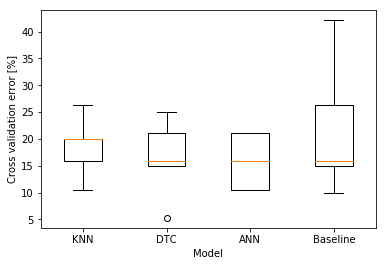

In [46]:
# The two best performing models are from dct and KNN
print('Outer error dct is' + str(error_dct))
print('Outer error of KNN is' + str(error_KNN))
print('Outer error of ANN is' + str(error_ANN))
print('Outer error of baseline_model is' + str(error_baseline))

figure()
boxplot([error_KNN, error_dct, error_ANN, error_baseline])
xlabel('Model')
ylabel('Cross validation error [%]')
xticks([1, 2, 3, 4], ['KNN', 'DTC', 'ANN', 'Baseline'])
       

### Comparison of methods (based on all the different models)

In [45]:
# The best performing classifiers are KNN and dtc

## Crossvalidation
# Create crossvalidation partition for evaluation
K = K_outer
CV = model_selection.KFold(n_splits=K,shuffle=True, random_state=seed)
#CV = model_selection.StratifiedKFold(n_splits=K)

# Initialize variables
Error_base_line = np.asarray(error_baseline)
Error_model_1 = np.asarray(error_dct)
Error_model_2 = np.asarray(error_KNN)

# Comparison of Baseline model with model 1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_1)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and baseline model are not significantly different')        
else:
    print('Model 1 and baseline model are significantly different.')
print('zb:' +str(zb))
print('sig:' + str(sig))
print('zL:' + str(zL))
print('zH:' +str(zH))

# Comparison of Baseline model with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Baseline model and Model 2 are not significantly different')        
else:
    print('Baseline model and Model 2 are significantly different.')
print('zb:' +str(zb))
print('sig:' + str(sig))
print('zL:' + str(zL))
print('zH:' +str(zH))

# Comparison of model 1 with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_model_1-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and Model 2 are not significantly different')        
else:
    print('Model 1 and Model 2 are significantly different.')
print('zb:' +str(zb))
print('sig:' + str(sig))
print('zL:' + str(zL))
print('zH:' +str(zH))
print(K)

Model 1 and baseline model are not significantly different
zb:5.421052631578947
sig:6.574524829316712
zL:-12.832754649778837
zH:23.674859912936725
Baseline model and Model 2 are not significantly different
zb:3.315789473684211
sig:5.332179007121659
zL:-11.488712830677182
zH:18.1202917780456
Model 1 and Model 2 are not significantly different
zb:-2.1052631578947363
sig:2.0401102571909795
zL:-7.769517295536455
zH:3.558990979746981
5


# Gammel kode

### Comparison of two single models (selected based on error) 

In [42]:
# The best performing classifiers are KNN with K = 2 and a dtc with tc=10

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True, random_state=seed)
#CV = model_selection.StratifiedKFold(n_splits=K)

# Initialize variables
Error_base_line = np.empty((K,1))
Error_model_1 = np.empty((K,1))
Error_model_2 = np.empty((K,1))

n_tested=0

k=0
for train_index, test_index in CV.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K))
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]

    # Fit and evaluate KNN
    model1 = KNeighborsClassifier(n_neighbors=2, p=dist);
    model1 = model1.fit(X_train, y_train)
    y_model1 = model1.predict(X_test)
    Error_model_1[k] = 100*(y_model1!=y_test).sum().astype(float)/len(y_test)
    
    # Fit and evaluate Decision Tree classifier
    model2 = tree.DecisionTreeClassifier(criterion='gini', max_depth=10);
    model2 = model2.fit(X_train, y_train.ravel())
    y_model2 = model2.predict(X_test)
    Error_model_2[k] = 100*(y_model2!=y_test).sum().astype(float)/len(y_test)  
    
    # Fit and evaluate baseline model classifier
    y_baseline = Baseline_model(y_train, y_test);
    Error_base_line[k] = 100*(y_baseline!=y_test).sum().astype(float)/len(y_test)
  
    k+=1

# Comparison of Baseline model with model 1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_1)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and baseline model are not significantly different')        
else:
    print('Model 1 and baseline model are significantly different.')
print(zL)
print(zH)

# Comparison of Baseline model with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Baseline model and Model 2 are not significantly different')        
else:
    print('Baseline model and Model 2 are significantly different.')
print(zL)
print(zH)

# Comparison of model 1 with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_model_1-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and Model 2 are not significantly different')        
else:
    print('Model 1 and Model 2 are significantly different.')
print(zL)
print(zH)

CV-fold 1 of 10


NameError: name 'y' is not defined

In [21]:
# Initialize variables
Error_base_line = min(error_baseline)
Error_model_1 = min(error_dct) # Gives the best performing model
Error_model_2 = sorted(error_dct)[1] # Gives the second best performing model

# Comparison of Baseline model with model 1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_1)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and baseline model are not significantly different')        
else:
    print('Model 1 and baseline model are significantly different.')
print(zL)
print(zH)

# Comparison of Baseline model with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2);
zH = zb + sig * stats.t.ppf(1-alpha/2);

if zL <= 0 and zH >= 0 :
    print('Model 2 and baseline model are not significantly different')        
else:
    print('Model 2 and baseline model are significantly different.')
print(zL)
print(zH)

# Comparison of model 1 with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_model_1-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and Model 2 are not significantly different')        
else:
    print('Model 1 and Model 2 are significantly different.')
print(zL)
print(zH)

Model 1 and baseline model are significantly different.
5.0
5.0


TypeError: _parse_args() missing 1 required positional argument: 'df'

### Two level cross validation for KNN - Greta

In [ ]:
## Crossvalidation for KNN
# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True, random_state=seed)
#CV = model_selection.StratifiedKFold(n_splits=K)
index_min_lst = []
min_indices = []
error_outer = [] # List for the errors in outer CV fold

# Initialize variables
#Error_logreg = np.empty((K_outer,1))
#Error_KNN_inner = np.empty((K_inner,3))
#Error_NaïveB = np.empty((K_outer,1))
#n_tested=0

K_KNN = [1, 2, 3] # Change here for different nearest neighbour crossvalidation

k=0
classifier_lst = []

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True, random_state=seed)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        
        for count, value in enumerate(K_KNN):
            dist=1
    
            knclassifier = KNeighborsClassifier(n_neighbors=value, p=dist);
            knclassifier.fit(X_train_inner, y_train_inner);
            classifier_lst.append(knclassifier)
            
            y_KNN = knclassifier.predict(X_test_inner);
            errorKNN_inner = 100*(y_KNN!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            index_min_lst.append(errorKNN_inner) #Append the error values to a list
            
        # Find the KNN value with least error value
        index_min = np.argmin(index_min_lst) #Find the index of the minimum error value
        min_indices.append(index_min) 
        
        index_min_lst = [] # Clear for next CV fold
        
        kk += 1

        counts = np.bincount(min_indices) # Count which index appears the maximum number of times = i.e. the must be the least error value
        top_count = np.argmax(counts)
        # Only use the count from the last iteration! 
        optimal_K = K_KNN[top_count]
        
    print('The index of optimal KNN value is: ' + str(top_count))

    print('The optimal KNN value across inner CV folds is: ' + str(optimal_K))
    
    knclassifierOuter = KNeighborsClassifier(n_neighbors=optimal_K, p=dist); #Uses optimal_K, which was found in the inner CV loop
    knclassifierOuter.fit(X_train_outer, y_train_outer);
            
    y_KNN_outer = knclassifier.predict(X_test_outer);
    errorKNN_outer = 100*(y_KNN_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer.append(errorKNN_outer)
    print('Errors for each outer CV fold: ' + str(error_outer))
    
        
    

In [ ]:
## Crossvalidation for KNN
# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True, random_state=seed)
#CV = model_selection.StratifiedKFold(n_splits=K)
errorKNN_inner_GT=[]
errorKNN_outer_GT = []
index_min_lst = []
min_indices = []
error_outer = []

# Initialize variables
#Error_logreg = np.empty((K_outer,1))
#Error_KNN_inner = np.empty((K_inner,3))
#Error_NaïveB = np.empty((K_outer,1))
#n_tested=0

K_KNN = range(1,41)

k=0
classifier_lst = []

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True, random_state=seed)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        
        for count, value in enumerate(K_KNN):
            dist=1
    
            knclassifier = KNeighborsClassifier(n_neighbors=value, p=dist);
            knclassifier.fit(X_train_inner, y_train_inner);
            classifier_lst.append(knclassifier)
            
            y_KNN = knclassifier.predict(X_test_inner);
            errorKNN_inner_GT = 100*(y_KNN!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            index_min_lst.append(errorKNN_inner_GT) #Append the error values to a list
            
        # Find the KNN value with least error value
        index_min = np.argmin(index_min_lst) #Find the index of the minimum error value
        min_indices.append(index_min) 
        
        index_min_lst = [] # Clear for next CV fold
        
        kk += 1

    print(min_indices)
    counts = np.bincount(min_indices) # Count which index appears the maximum number of times = i.e. the must be the least error value
    top_count = np.argmax(counts)
    print('The index of optimal KNN value is: ' + str(top_count))
    
    # Only use the count from the last iteration! 
    optimal_K = K_KNN[top_count]
    print('The optimal KNN value across inner CV folds is: ' + str(optimal_K))
    
    knclassifierOuter = KNeighborsClassifier(n_neighbors=1, p=dist);
    knclassifierOuter.fit(X_train_outer, y_train_outer);
            
    y_KNN_outer = knclassifier.predict(X_test_outer);
    errorKNN_outer_GT = 100*(y_KNN_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer.append(errorKNN_outer_GT)
    print(error_outer)
    
        
    

In [29]:
### OBS. method can not use X values < 0

## Crossvalidation for Naive Bayes
## The selection of optimal model is based on an average of the inner errors for each model

# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True, random_state=seed)
#CV = model_selection.StratifiedKFold(n_splits=K)
index_min_lst = []
min_indices = []
error_outer = np.empty((1,1)) # List for the errors in outer CV fold
dict_inner = {}
error_inner = {} # Dict with the errors in the innter CV fold for each tested model

# Naive Bayes classifier parameters
alpha = [1]         # additive parameter (e.g. Laplace correction), lægges til da log bliver taget i MultinormilNB

for count, value in enumerate(K_KNN):
    error_inner['K_KNN_of_{0}'.format(value)] = []

k=0
classifier_lst = []

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        print(X_train_inner) 
        for count, value in enumerate(alpha):
            est_prior = True  # uniform prior (change to True to estimate prior from data)    
                       
            nbclassifier = MultinomialNB(alpha=alpha, fit_prior=est_prior);
            nbclassifier.fit(X_train_inner, y_train_inner);
            classifier_lst.append(nbclassifier)
 
            y_NB = nbclassifier.predict(X_test_inner);
            errorNB_inner = 100*(y_NB!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            #index_min_lst.append(errorKNN_inner) #Append the error values to a list
            error_inner['alpha_of_{0}'.format(value)].append(errorNB_inner) # add errors for each fold to each model
            
        kk += 1
        
    # Find the alpha value with minimum average error value
    for key in error_inner.keys():
        index_min_lst.append(mean(error_inner[key]))
        
    print('Inner_error_values are:' + str(index_min_lst))
    index_min = np.argmin(index_min_lst) #Find the index of the minimum error value
    top_count = index_min
    min_indices.append(index_min) 
        
    index_min_lst = [] # Clear for next CV fold
    
    for key in error_inner.keys():
        error_inner[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal KNN value is: ' + str(top_count))
    
    optimal_alpha = alpha[top_count]
    
    print('The optimal KNN value across inner CV folds is: ' + str(optimal_K))
    
    nbclassifierOuter = MultinomialNB(alpha=optimal_alpha, fit_prior=est_prior); #Uses optimal_alpha, which was found in the inner CV loop
    nbclassifierOuter.fit(X_train_outer, y_train_outer);
            
    y_NB_outer = nbclassifier.predict(X_test_outer);
    errorNB_outer = 100*(y_NB_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer.append(errorNB_outer)
    print('Errors for each outer CV fold: ' + str(error_outer))


CV-fold 1 of 5
Inner CV-fold 1 of 5
[[-1.9993129  -0.72575948 -0.79198919 -1.03002898 -0.86765522 -2.29971238
   1.          0.          0.          0.        ]
 [-1.58702059 -2.20015441  1.36823439 -1.03002898 -0.86765522 -2.29971238
   0.          1.          0.          0.        ]
 [-0.5105128  -0.46121762 -0.25193329 -1.03002898 -0.86765522 -1.83463099
   1.          0.          0.          0.        ]
 [-2.04670586 -0.93880639 -1.87210098 -1.03002898 -0.86765522 -1.49161747
   1.          0.          0.          0.        ]
 [-0.5226677  -0.3646778   0.01809466  0.35670122 -0.86765522 -1.49161747
   1.          0.          0.          0.        ]
 [-0.56020767 -0.20984103 -0.79198919  0.99529051 -0.86765522 -1.4141616
   1.          0.          0.          0.        ]
 [-1.81362657 -0.20984103 -2.2771429  -1.03002898 -0.86765522 -1.24618021
   1.          0.          0.          0.        ]
 [-0.9610521  -0.90192675 -0.11691932 -1.03002898 -0.86765522 -1.24618021
   1.          0

ValueError: Input X must be non-negative